# Data streaming

## Flow classification task – 1 A4

Group 97

Study paper 3 and construct a classifier for detecting anomalous behavior in individual NetFlows (every flow is a row, ignoring sequences). Do not forget to study and deal with properties of your data such as class imbalance. Evaluate your method in two ways: on the packet level (as in paper 3), and on the host level (as in paper 4). Do you prefer using a sequential model or a classifier for detecting botnets? Explain why.

## Data Preparation

In [226]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.ensemble import RandomForestClassifier


np.random.seed(42)
random.seed(42)
%matplotlib inline

In [17]:
# define filepath for scenario 1 dataset
filepath = './data/capture20110811.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [18]:
def preprocessing_remove_Background(data):
    '''data preprocessing
    Input
    -----
    string of a data flow
    
    Return
    ------
    None, if Background flow (to be removed)
    else cleaned, formated data
    '''
    if not 'Background' in data:
        s = data.split('\t')
        s = [x for x in s if x] # remove empty elements
        if len(s) < 12: # special fix for an outlier string @2011-08-18 12:18:31.264
            s = s[0].rsplit(' ', 11) 
        o = np.array([datetime.strptime(s[0], '%Y-%m-%d %H:%M:%S.%f').timestamp(), #time
                      float(s[1]), # duration
                      s[2], # protocol
                      s[3].split(':')[0], # ScrAddr
                      s[5].split(':')[0], # DstAddr
                      s[6].lstrip('_').rstrip('_').rstrip(), # flags
                      int(s[7]), # Tos
                      int(s[8]), # packets
                      int(s[9]), # bytes
                      int(s[10]), # flows
                      s[11].rstrip('\n').rstrip() # label
                     ])
    else:
        o = None
    return o

In [105]:
df = list(map(preprocessing_remove_Background, data)) # data preprocessing
df = [x for x in df if isinstance(x, np.ndarray)] # remove background flows
df = pd.DataFrame(df, columns=['Time', 'Duration', 'Protocol', 'ScrAddr', 'DstAddr', 
                               'Flags', 'Tos', 'Packets', 'Bytes', 'Flows', 'Label'])

# fix dtype again due to removal of background flows
df.Time = df.Time.astype(float)
df.Duration = df.Duration.astype(float)
df.Packets = df.Packets.astype(int)
df.Bytes = df.Bytes.astype(int)

Looking at the DataFrame

In [106]:
df.head()

,Time,Duration,Protocol,ScrAddr,DstAddr,Flags,Tos,Packets,Bytes,Flows,Label
0,1.313050e+09,1.915,TCP,147.32.85.76,74.125.232.198,FSPA,0,10,2334,1,LEGITIMATE
1,1.313050e+09,1.901,TCP,147.32.85.76,74.125.232.198,FSPA,0,7,3011,1,LEGITIMATE
2,1.313050e+09,0.000,TCP,147.32.84.59,74.125.232.213,A,0,1,66,1,LEGITIMATE
3,1.313050e+09,0.000,TCP,147.32.84.59,74.125.232.203,A,0,2,132,1,LEGITIMATE
4,1.313050e+09,0.000,TCP,147.32.85.5,74.125.232.213,A,0,1,66,1,LEGITIMATE


Checking if the Infected Host is in either column ScrAddr or DstAddr for all the labels 'Botnet'

In [107]:
INFECTED_HOST = '147.32.84.165'
len( df[(df['ScrAddr'] == INFECTED_HOST) | (df['DstAddr'] == INFECTED_HOST)] ) == len( df[df['Label'] == "Botnet"] )

True

## Packet Level classification

#### Data Exploration - Verifying if the data is unbalanced

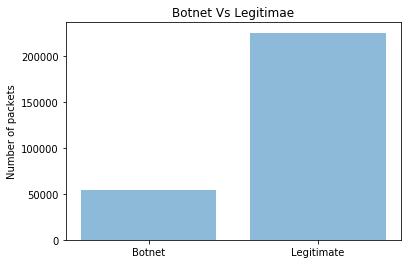

Percentage of Botnets/Total: 19.0%


In [211]:
len_labels = [len(df[df['Label']=="Botnet"]),len(df[df['Label']!="Botnet"])]

plt.bar(["Botnet","Legitimate"],len_labels, align='center', alpha=0.5)
plt.ylabel('Number of packets')
plt.title('Botnet Vs Legitimae')
plt.show()

print("Percentage of Botnets/Total: "+str(round(len(df[df['Label']=="Botnet"])/(len(df)),2)*100)+'%')

#### Data Preparation

In [143]:
pl_df = df.copy()

Dropping the columns that should not be used and separating the DF into features and labels

In [144]:
y = pl_df['Label']
X = pl_df.drop(columns=['Label','ScrAddr','DstAddr','Flows','Time'])
y=y.apply(lambda x: 0 if x=="LEGITIMATE" else 1)

#### Encoding

Checking variables to encode

In [145]:
X.dtypes
#X.value_counts()

Time        float64
Duration    float64
Protocol     object
Flags        object
Tos          object
Packets       int32
Bytes         int32
dtype: object

Checking how many columns will be created

In [146]:
for column in X.columns:
    if is_numeric_dtype(X[column])==False:
        print(column+" | "+str(len(set(pl_df[column]))))

Protocol | 4
Flags | 28
Tos | 2


Encoding

In [147]:
X=pd.get_dummies(X, columns=["Protocol", "Flags","Tos"], prefix=["Protocol", "Flags","Tos"])
X.head()

,Time,Duration,Packets,Bytes,Protocol_ICMP,Protocol_RTCP,Protocol_TCP,Protocol_UDP,Flags_A,Flags_ECO,...,Flags_SRA,Flags_SRPA,Flags_TXD,Flags_URFIL,Flags_URH,Flags_URHPRO,Flags_URN,Flags_URP,Tos_0,Tos_2
0,1.313050e+09,1.915,10,2334,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.313050e+09,1.901,7,3011,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.313050e+09,0.000,1,66,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1.313050e+09,0.000,2,132,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1.313050e+09,0.000,1,66,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


#### Scaling

Scaling the data

In [154]:
X.loc[:,["Duration","Packets","Bytes"]]=preprocessing.scale(X.loc[:,["Duration","Packets","Bytes"]])
X.head()

C:\Users\pvbia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


,Time,Duration,Packets,Bytes,Protocol_ICMP,Protocol_RTCP,Protocol_TCP,Protocol_UDP,Flags_A,Flags_ECO,...,Flags_SRA,Flags_SRPA,Flags_TXD,Flags_URFIL,Flags_URH,Flags_URHPRO,Flags_URN,Flags_URP,Tos_0,Tos_2
0,1.313050e+09,0.794487,-0.077597,-0.075359,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.313050e+09,0.784529,-0.098008,-0.071302,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.313050e+09,-0.567612,-0.138831,-0.088951,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1.313050e+09,-0.567612,-0.132027,-0.088555,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1.313050e+09,-0.567612,-0.138831,-0.088951,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Training the ML model and dealing with Unbalanced data

Spliting the data and removing columns that should not be used in the prediction.

In [224]:
n_neighbors = [1,2,3,4,5]
n_trees=[10,50,100,150,200]

smote_percantages = [0.25, 0.5,0.75, 1.0]

Spliting the data into train and test set

In [216]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Split the train set into train and validation to use for parameter selection

In [217]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

Running the loop to pick the best parameters in the train set

In [ ]:
f1_score = pd.DataFrame(columns=['Algorithm','Smote_percentage','N_neighbor/N_trees','F1'])
index=0
seed=42

for smote_percantage in smote_percantages:
    
    #Generating the SMOTEd data set
    X_smote, y_smote = SMOTE(random_state = seed,sampling_strategy=smote_percantage).fit_resample(X_train, y_train)
    
    for n_neighbor in n_neighbors:
        
        #Learning the model
        model=KNeighborsClassifier(n_neighbors=n_neighbor, n_jobs=-1)
        model.fit(X_smote, y_smote)
        y_pred = model.predict(X_val)
        #Calculating the F1-score and saving in the DF
        f1_score.loc[index]=["KNN",smote_percantage,n_neighbor,metrics.f1_score(y_val, y_pred)]
        index += 1
        
        
    for tree in n_trees:
        
        #Learning the model
        model=RandomForestClassifier(n_estimators=tree, n_jobs=-1)
        model.fit(X_smote, y_smote)
        y_pred = model.predict(X_val)
        #Calculating the F1-score and saving in the DF
        f1_score.loc[index]=["Random Forest",smote_percantage,tree,metrics.f1_score(y_val, y_pred)]
        index += 1

In [228]:
f1_score.sort_values('F1', ascending=False)

,Algorithm,Smote_percentage,N_neighbor/N_trees,F1
8,Random Forest,0.25,5,0.957517
9,Random Forest,0.25,5,0.956938
18,Random Forest,0.50,5,0.956854
6,Random Forest,0.25,5,0.956598
7,Random Forest,0.25,5,0.956246
17,Random Forest,0.50,5,0.956055
19,Random Forest,0.50,5,0.955985
26,Random Forest,0.75,5,0.955527
29,Random Forest,0.75,5,0.955388
39,Random Forest,1.00,5,0.955210


In [ ]:
for (clsf_name, clsf), best_smote in zip(classifiers, best_smotes):
    print(f"{clsf_name} --> best smote param: {best_smote}")

    fpr_smoted = []
    tpr_smoted = []
    if best_smote:
        smt = SMOTE(sampling_strategy=best_smote)
        X_smote, y_smote = smt.fit_sample(X_train_val, y_train_val)
        clsf.fit(X_smote, y_smote)
        y_pred = clsf.predict(X_test)

        probs_smoted = clsf.predict_proba(X_test)
        probs_smoted = probs_smoted[:, 1]
        fpr_smoted, tpr_smoted, _ = roc_curve(y_test, probs_smoted)
        plt.plot(fpr_smoted, tpr_smoted, color='red', label=f'best SMOTEd ({best_smote})')

    clsf.fit(X_train_val, y_train_val)
    y_pred = clsf.predict(X_test)
    probs_smoted = clsf.predict_proba(X_test)
    probs_smoted = probs_smoted[:, 1]
    fpr_unsmoted, tpr_unsmoted, _ = roc_curve(y_test, probs_smoted)
    plt.plot(fpr_unsmoted, tpr_unsmoted, color='blue', label='UNSMOTEd' if best_smote else 'UNSMOTEd (best)')

    if best_smote < 1:
        smt = SMOTE(sampling_strategy=1.0)
        X_full_smote, y_full_smote = smt.fit_sample(X_train_val, y_train_val)
        clsf.fit(X_full_smote, y_full_smote)
        y_pred = clsf.predict(X_test)

    probs_smoted = clsf.predict_proba(X_test)
    probs_smoted = probs_smoted[:, 1]
    fpr_smoted, tpr_smoted, _ = roc_curve(y_test, probs_smoted)
    plt.plot(fpr_smoted, tpr_smoted, color='orange', label="SMOTE (1.0)")
        
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {clsf_name} (best SMOTE: {best_smote})')
    plt.legend()
    plt.show()